# ***Optimizasyon Yöntemlerinin Karşılaştırılması***

**Bu kod, MNIST veri seti üzerinde farklı optimizasyon algoritmalarının performansını karşılaştıran bir derin öğrenme modeli oluşturuyor.**

*MNIST, el yazısı rakamların bulunduğu, makine öğrenimi ve derin öğrenme modelleriyle çalışırken kullanılan popüler bir veri setidir. Örneğin, içinde 0'dan 9'a kadar yazılmış 60.000 eğitim ve 10.000 test örneği bulunur.*

### Kütüphanelerin kurulması ve gerekli importların yapılması adımı

Bu bölümde, Keras, TensorFlow ve matplotlib gibi gerekli kütüphaneler yüklenir ve kullanıma hazır hale getirilir.import ifadeleriyle de gerekli modüller projeye dahil edilir.

In [ ]:
!pip install -q keras    # Keras kütüphanesi Colab ortamına kurulur

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow  as tf
from keras.layers import *
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

### Veri Setinin İndirilmesi

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


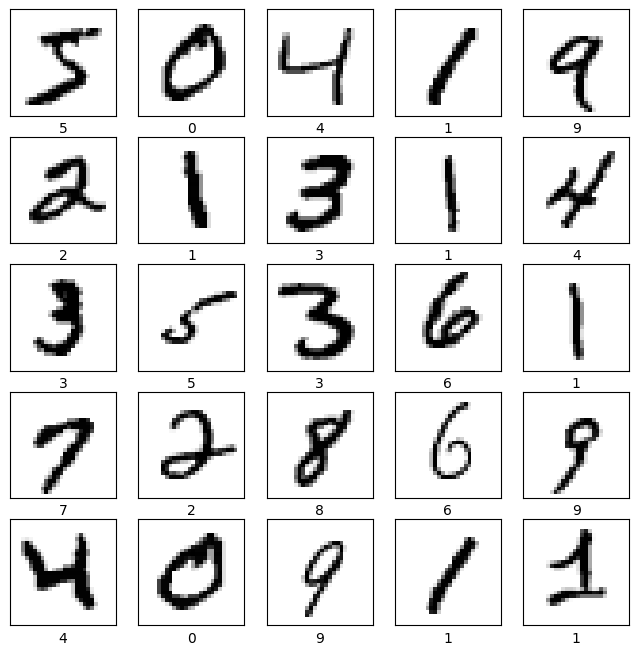

In [ ]:
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

### Yapılandırma Ayarları
Küme boyutu, sınıf sayısı, eğitim epoch sayısı gibi parametreleri tüm optimizasyon denemeleri için aynı şekilde ayarlıyoruz!

In [ ]:
batch_size = 128 # Küme Boyutu (Her eğitim adımında kaç örneğin işleneceği)
num_classes = 10 # Sınıf Sayısı (MNIST veri setinde 10 rakam sınıfı olduğu için 10)
epochs = 10 # Modelin tüm eğitim verisi üzerinde kaç kez eğitileceği
w_l2 = 1e-5 # Başlangıç düzenlileştirme katsayısı.

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
# Öğrenme oranını azaltmak için kullanılan geri çağırma fonksiyonu.

In [ ]:
img_rows, img_cols = 28, 28

# Görüntüler, modelin beklediği formata uygun hale getirilir
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255  #piksel normalizasyonu
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Etiketler, modelin çıktısıyla uyumlu olması için kategorik hale getirilir
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
from keras import optimizers  #farklı optimizasyon algoritmalarını içeren bir modüldür.

### Tüm optimizasyon yöntemlerini eğiteceğimiz CNN modelinin oluşturulması

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Model, 14 katmandan oluşur ve sırasıyla: iki Convolutional katman, BatchNormalization, ReLU aktivasyonu, MaxPooling, Dropout, Flatten, Dense katmanları içerir. Sonuç olarak, sınıflandırma için softmax aktivasyonu ile num_classes kadar çıkış sağlar.

### STOKASTİK GRADYAN İNİŞ OPTİMİZASYONU

Tüm örneklerden geçmek yerine, Stokastik Degrade İniş (SGD), her bir örnekte $(x ^ i, y ^ i)$  parametrelerin güncellenmesini gerçekleştirir. Bu nedenle, öğrenme her örnekte gerçekleşir:

$w = w− α∇wJ(x^i,y^i;w,b)$

```
for i in range(num_epochs):
    np.random.shuffle(data)
    for example in data:
        grad = compute_gradient(example, params)
        params = params - learning_rate * grad
```

Aşağıdaki kod bloğu, modelin eğitim sürecini başlatmak için kayıp fonksiyonu, optimizasyon algoritması ve izlenecek metriği belirleyip modelin derlenmesini sağlar.

Modeli derlemek, modelin eğitim sürecini başlatabilmek için gerekli olan tüm bileşenleri (kaybı, optimizasyonu ve metriği) tanımlamak anlamına gelir. Bu işlemden sonra model eğitim verisi üzerinde eğitilmeye hazır hale gelir.

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])   #model derlenir

model.summary()  #modelin yapısını ve katmanlarının özetini ekrana yazdırır

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,778 (4.58 MB)

 Trainable params: 1,200,330 (4.58 MB)

 Non-trainable params: 448 (1.75 KB)

###SGD - Modelin Eğitim ve Test Sonuçları

In [ ]:
hist_SGD=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])   #model eğitimi
score = model.evaluate(x_test, y_test, verbose=0)  #test verisiyle değerlendirilmesini
print('Test loss:', score[0])
print('Test accuracy:', score[1])   #kayıp ve doğruluk değerlerinin yazdırılması

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 209s 441ms/step - accuracy: 0.7637 - loss: 0.7851 - val_accuracy: 0.8548 - val_loss: 0.5652 - learning_rate: 0.0100
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 252s 420ms/step - accuracy: 0.9354 - loss: 0.2412 - val_accuracy: 0.9747 - val_loss: 0.1027 - learning_rate: 0.0100
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 426ms/step - accuracy: 0.9533 - loss: 0.1825 - val_accuracy: 0.9780 - val_loss: 0.0829 - learning_rate: 0.0100
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 196s 413ms/step - accuracy: 0.9611 - loss: 0.1486 - val_accuracy: 0.9816 - val_loss: 0.0722 - learning_rate: 0.0100
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 207s 425ms/step - accuracy: 0.9664 - loss: 0.1311 - val_accuracy: 0.9819 - val_loss: 0.0631 - learning_rate: 0.0100
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 198s 416ms/step - accuracy: 0.9697 - loss: 0.1187 - val_accuracy: 0.9846 - val_loss: 0.0580 - learning_rate: 0.0100
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 192s 408ms/step - accura

### ADAM OPTİMİZASYONU
***Adam veya adaptif momentum AdaDelta’ya benzer bir algoritmadır. AdaDelta’dan farklı olarak parametrelerin her birinin öğrenme oranlarının yanısıra momentum değişikliklerini de önbellekte (cache) saklar; yani RMSprop ve momentumu birleştirir.***

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,778 (4.58 MB)

 Trainable params: 1,200,330 (4.58 MB)

 Non-trainable params: 448 (1.75 KB)

###ADAM - Modelin Eğitim ve Test Sonuçları

In [ ]:
hist_ADAM=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 426ms/step - accuracy: 0.9639 - loss: 0.1268 - val_accuracy: 0.9856 - val_loss: 0.0464 - learning_rate: 0.0010
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 194s 408ms/step - accuracy: 0.9795 - loss: 0.0753 - val_accuracy: 0.9864 - val_loss: 0.0497 - learning_rate: 0.0010
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 208s 421ms/step - accuracy: 0.9851 - loss: 0.0602 - val_accuracy: 0.9906 - val_loss: 0.0378 - learning_rate: 0.0010
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 199s 414ms/step - accuracy: 0.9865 - loss: 0.0562 - val_accuracy: 0.9901 - val_loss: 0.0402 - learning_rate: 0.0010
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 415ms/step - accuracy: 0.9886 - loss: 0.0507 - val_accuracy: 0.9916 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 197s 404ms/step - accuracy: 0.9902 - loss: 0.0471 - val_accuracy: 0.9918 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 400ms/step - accura

### RMSprop OPTİMİZASYONU

***RMSprop ve benzeri olan AdaDelta, AdaGrad’ın bu sorununu çözerek bu hızlı düşüşü önler.***

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,778 (4.58 MB)

 Trainable params: 1,200,330 (4.58 MB)

 Non-trainable params: 448 (1.75 KB)

###RMSprop - Modelin Eğitim ve Test Sonuçları

In [ ]:
hist_RMSprob=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 196s 413ms/step - accuracy: 0.9941 - loss: 0.0362 - val_accuracy: 0.9921 - val_loss: 0.0438 - learning_rate: 0.0010
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 195s 398ms/step - accuracy: 0.9944 - loss: 0.0353 - val_accuracy: 0.9916 - val_loss: 0.0447 - learning_rate: 0.0010
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 400ms/step - accuracy: 0.9949 - loss: 0.0331 - val_accuracy: 0.9925 - val_loss: 0.0421 - learning_rate: 0.0010
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 187s 398ms/step - accuracy: 0.9947 - loss: 0.0336 - val_accuracy: 0.9928 - val_loss: 0.0445 - learning_rate: 0.0010
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 400ms/step - accuracy: 0.9952 - loss: 0.0323 - val_accuracy: 0.9927 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 405ms/step - accuracy: 0.9945 - loss: 0.0334 - val_accuracy: 0.9906 - val_loss: 0.0513 - learning_rate: 0.0010
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 400ms/step - accura

### ADAGRAD OPTİMİZASYONU

***AdaGrad seyrek parametreler için büyük güncellemeler yaparken sık parametreler için daha küçük güncellemeler yapar. Bu nedenle NLP ve resim tanıma gibi seyrek veriler için daha uygundur.***
AdaGrad’da her parametrenin kendi öğrenme hızı vardır ve algoritmanın özelliklerine bağlı olarak öğrenme oranı giderek azalmaktadır. Bu nedenle öğreneme oranı giderek azalır ve zamanın bir noktasında sistem öğrenmeyi bırakır. Bu AdaGrad’ın en büyük dez avantajıdır.

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adagrad(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,778 (4.58 MB)

 Trainable params: 1,200,330 (4.58 MB)

 Non-trainable params: 448 (1.75 KB)

###AdaGrad - Modelin Eğitim ve Test Sonuçları

In [ ]:
hist_adagrad=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 192s 406ms/step - accuracy: 0.9965 - loss: 0.0300 - val_accuracy: 0.9924 - val_loss: 0.0443 - learning_rate: 0.0010
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 410ms/step - accuracy: 0.9964 - loss: 0.0302 - val_accuracy: 0.9926 - val_loss: 0.0439 - learning_rate: 0.0010
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 407ms/step - accuracy: 0.9957 - loss: 0.0305 - val_accuracy: 0.9926 - val_loss: 0.0439 - learning_rate: 0.0010
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 409ms/step - accuracy: 0.9962 - loss: 0.0296 - val_accuracy: 0.9929 - val_loss: 0.0439 - learning_rate: 0.0010
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 413ms/step - accuracy: 0.9959 - loss: 0.0307 - val_accuracy: 0.9927 - val_loss: 0.0436 - learning_rate: 0.0010
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 191s 408ms/step - accuracy: 0.9969 - loss: 0.0271 - val_accuracy: 0.9928 - val_loss: 0.0436 - learning_rate: 0.0010
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 413ms/step - accura

### ADADELTA OPTİMİZASYONU
***AdaDelta, AdaGrad’ın bu sorununu çözerek bu hızlı düşüşü önler.***

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,778 (4.58 MB)

 Trainable params: 1,200,330 (4.58 MB)

 Non-trainable params: 448 (1.75 KB)

###AdaDelta - Modelin Eğitim ve Test Sonuçları

In [ ]:
hist_adadelta=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 427ms/step - accuracy: 0.9966 - loss: 0.0285 - val_accuracy: 0.9927 - val_loss: 0.0435 - learning_rate: 0.0010
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 426ms/step - accuracy: 0.9967 - loss: 0.0286 - val_accuracy: 0.9928 - val_loss: 0.0435 - learning_rate: 0.0010
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 199s 420ms/step - accuracy: 0.9965 - loss: 0.0298 - val_accuracy: 0.9928 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 196s 418ms/step - accuracy: 0.9965 - loss: 0.0278 - val_accuracy: 0.9929 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 195s 404ms/step - accuracy: 0.9968 - loss: 0.0275 - val_accuracy: 0.9929 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 205s 411ms/step - accuracy: 0.9964 - loss: 0.0284 - val_accuracy: 0.9928 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 192s 410ms/step - accura

## Kaydedilen sonuçların çizilmesi için plot fonksiyonunun tanımlanması ve sonuçların karşılaştırılması

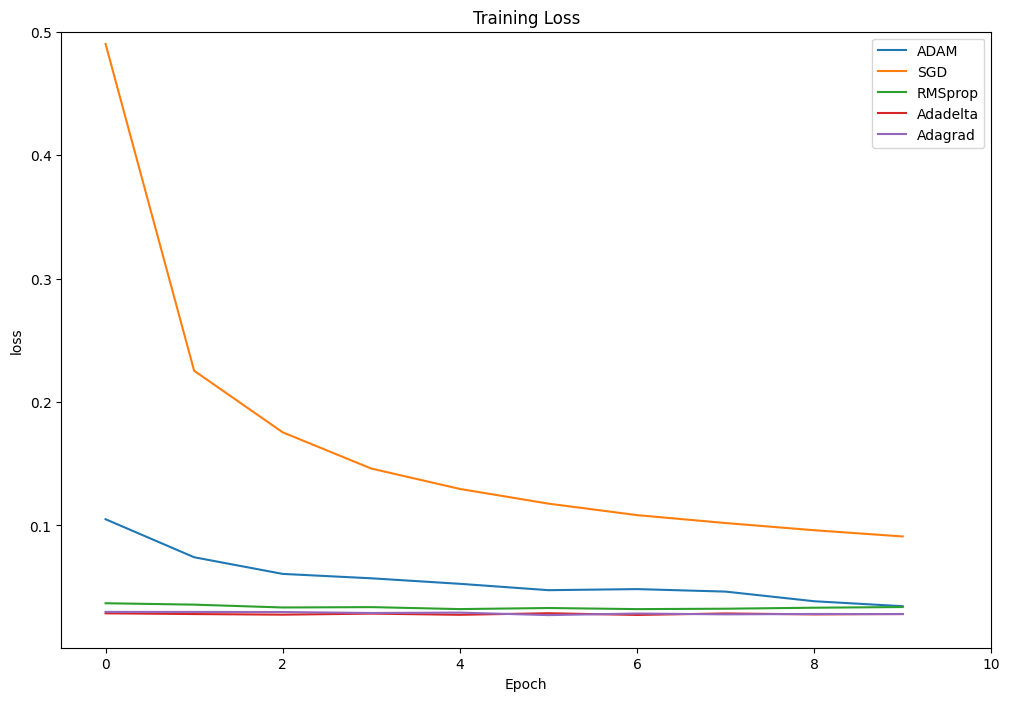

In [ ]:

def plot_history(hists, attribute='val_loss', axis=(-1, 21, 0.85, 0.94), loc='lower right'):
    # Y ekseni etiketleri
    ylabel = {'loss': 'loss', 'acc': 'accuracy'}

    # Başlıklar
    title = {
        'val_loss': 'Validation Loss',
        'loss': 'Training Loss',
        'val_acc': 'Validation Accuracy',
        'acc': 'Training Accuracy',
        'accuracy': 'Training Accuracy',  # Eğer 'accuracy' kullanıyorsanız
        'val_accuracy': 'Validation Accuracy'  # Eğer 'val_accuracy' varsa
    }

    num_hists = len(hists)

    # Grafik ayarları
    plt.figure(figsize=(12, 8))
    plt.axis(axis)

    # Her bir geçmişi çizme
    for i in range(num_hists):
        plt.plot(hists[i].history[attribute])

    # Başlık ve etiketler
    plt.title(title[attribute])
    plt.ylabel(ylabel[attribute])  # Doğrudan attribute'yi kullanıyoruz
    plt.xlabel('Epoch')

    # Efsane
    plt.legend(['ADAM', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad'], loc=loc)

    # Grafiği gösterme
    plt.show()

# Eğitim geçmişi listesi (önceden tanımlanmış)
hists = [hist_ADAM, hist_SGD, hist_RMSprob, hist_adadelta, hist_adagrad]

# 'loss' çizmek için
plot_history(hists, attribute='loss', axis=(-0.5, 10, 0.0009, 0.5), loc='upper right')



# SONUÇ
---
Kullandığımız optimizasyon algoritmasına göre epoch süresince eğitim hatasının nasıl değiştiğini çizdirdiğimiz grafiklerden inceleyebiliyoruz.

### Test Yitim (Loss)  Değerlerini de aşağıdaki tablo ile inceleyeyim:


![TEST SONUÇLARI](https://i.hizliresim.com/alRa2B.png)

### Grafikteki Gözlemler
---
***ADAM (mavi çizgi):***

En düşük kayıp değerine hızlıca ulaşıyor.
Hızlı yakınsama özelliği gösteriyor, yani model hızla öğreniyor.


***SGD (turuncu çizgi):***

Başlangıçta yüksek bir kayıp değerine sahip, ancak zamanla kayıp düşüyor.
Daha yavaş yakınsıyor, ancak doğrulama sırasında aşırı öğrenmeye daha az yatkın olabilir.


***RMSprop, Adadelta, Adagrad:***

Daha stabil bir kayıp azalışına sahip.
Kayıp değerleri diğerlerine göre biraz daha yüksek.

---
###Hangi Algoritma Daha İyi?

### Kısa vadede hızlı sonuç almak istiyorsanız: ADAM en iyi seçim olabilir.

### Aşırı öğrenmeden kaçınmak ve daha iyi genelleme sağlamak istiyorsanız: SGD veya RMSprop tercih edilebilir.

### Spesifik problem (örneğin, seyrek veri veya zaman serisi problemleri) varsa, Adadelta veya Adagrad uygun olabilir.